In [2]:
import numpy as np
from itertools import cycle
from math import pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [3]:
def swap_ind(state_r,ind): #auxiliary function swaps indices 
    for i in range (2**(ind-1)):
        state_r[[2*i,2*i+1],:]=state_r[[2*i+1,2*i],:]
    return state_r

def swap_sign(state_r,ind): #auxiliary function swaps signs
    for i in range (2**(ind-1)):
        state_r[2*i,:]=-state_r[2*i,:]
    return state_r

def x (state, ind): #X Pauli gate
    ind=ind+1
    state_c=np.copy(state)
    state_r=np.reshape(state_c,(2**ind,2**(n-ind)))
    state_r=swap_ind(state_r,ind)
    return state_r.flatten()

def y (state, ind): #Y Pauli gate
    ind=ind+1
    state_c=np.copy(state)
    state_r=np.reshape(state_c,(2**ind,2**(n-ind)))
    state_r=swap_ind(state_r,ind)
    state_r=swap_sign(state_r,ind)
    return 1j*state_r.flatten()


def z (state, ind): #Y Pauli gate
    ind=ind+1
    state_c=np.copy(state)
    state_r=np.reshape(state_c,(2**ind,2**(n-ind)))
    state_r=-swap_sign(state_r,ind)
    return state_r.flatten()

def rx (state, theta, ind):
    state_c=np.copy(state)
    state_X=x (state_c, ind)
    state_Rx=np.cos(theta)*state-1j*np.sin(theta)*state_X
    return state_Rx

def ry (state, theta, ind):
    state_c=np.copy(state)
    state_Y=y (state_c, ind)
    state_Ry=np.cos(theta)*state-1j*np.sin(theta)*state_Y
    return state_Ry

def rz (state, theta, ind):
    state_c=np.copy(state)
    state_Z=z (state_c, ind) 
    state_Rz=np.cos(theta)*state-1j*np.sin(theta)*state_Z
    return state_Rz


def ion1 (state, theta, ReE, ImE, Del, ind): #the hamiltonian is shifteed as we ignore the Identity term, Del= \omega-\omega_e+\omega_g, theta \in [0,T_max] such that |E| is constant 
    A=np.array([ReE,ImE,Del])
    a=np.linalg.norm(A)
    
    state_c=np.copy(state)
    state_X=x (state_c, ind)
    state_Y=y (state_c, ind)
    state_Z=z (state_c, ind) 
    state_ion1=np.cos(theta*a)*state_c-1j*np.sin(theta*a)*((ReE*state_X+ImE*state_Y+Del*state_Z)/a)
    return state_ion1
    


def rxx (state, theta, ind1, ind2):
    state_c=np.copy(state)
    state_X=x (state_c, ind1)
    state_X=x (state_X, ind2)
    state_Rx=np.cos(theta)*state-1j*np.sin(theta)*state_X
    return state_Rx

In [4]:
# (rz o rz)(rxx)(rx o rx)
def ising_entangler (state,pc,ind1,ind2):
    state=rz(state,next(pc),ind1)
    state=rz(state,next(pc),ind2)
    state=rxx(state,next(pc),ind1,ind2)
    state=rx(state,next(pc),ind1)
    state=rx(state,next(pc),ind2)
    return state

    
def checkerboard (state,n,p,pc):
    for _ in range(p):
        for ind_1 in range(n//2):
            state=ising_entangler(state,pc,2*ind_1,2*ind_1+1)
        for ind_2 in range(n//2-1):
            state=ising_entangler(state,pc,2*ind_2+1,2*ind_2+2)
        state=ising_entangler(state,pc,0,n-1)
    return state

def ion_1qubit_ansatz(state,p,pc):
    for _ in range(p):
        state=ion1 (state, next(pc), next(pc), next(pc), next(pc), 0)
    return state

## Overlap for a fixed depth

In [32]:
n=5
max_p=2

zeros=np.zeros(2**n) #initial state
zeros[0]=1


t=np.random.rand(2**n)+1j*np.random.rand(2**n) #target state (random by default)
t=t/np.linalg.norm(t)

params=np.random.rand(5*n*p)*2*pi


def cost (params):
    pc=cycle(params)#parmeters iterator
    
    
    psi=checkerboard(zeros,n,p,pc)
    
    olap=np.absolute(t.dot(psi))**2 # <--------THIS IS THE COST FUNCTION
    
    return 1-olap

res =  minimize(cost,params ,method='L-BFGS-B', jac=None, options={'maxiter': 300}) #THIS IS THE OPTIMIZER


psi=checkerboard(zeros,n,p,cycle(res.x)) #this is how you check the optimized state

## Overlap for a range of depths

In [4]:
n=5
max_p=4

zeros=np.zeros(2**n) #initial state
zeros[0]=1

#target state

t=np.random.rand(2**n)+1j*np.random.rand(2**n) #target state (random by default)
t=t/np.linalg.norm(t)

olaps=[]
for p in range(max_p):
    p=p+1
    params=np.random.rand(5*n*p)*2*pi


    def cost (params):
        pc=cycle(params)#parmeters iterator
        psi=checkerboard(zeros,n,p,pc)
        olap=np.absolute(t.dot(psi))**2 # <--------THIS IS THE COST FUNCTION
        return 1-olap
    
    res =  minimize(cost,params ,method='L-BFGS-B', jac=None, options={'maxiter': 300})
    print(cost(res.x))
    olaps.append(cost(res.x))

0.588411848905702
0.24270428142865985
0.012333676911508329
0.00044865790419412743


No handles with labels found to put in legend.


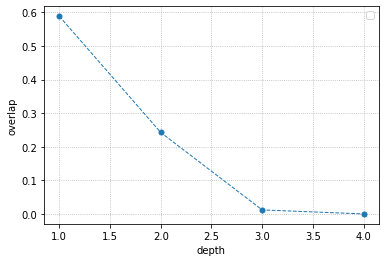

In [8]:
fig, ax = plt.subplots()
x=np.array([1,2,3,4])# Create a figure and an axes.
ax.plot(x, olaps, '--',marker='o', linewidth=1, markersize=5)
plt.grid(linestyle='dotted')

ax.set_xlabel('depth')  # Add an x-label to the axes.
ax.set_ylabel('1-overlap')  # Add a y-label to the axes.
ax.legend(loc='upper right')  # Ad
#fig.savefig('saturability2to10qubits.eps')

## Single qubit ansatz lol

In [103]:
n=1
p=1

zeros=np.zeros(2**n) #initial state
zeros[0]=1


t=np.random.rand(2**n)+1j*np.random.rand(2**n) #target state (random by default)
t=t/np.linalg.norm(t)

rand_m=np.random.rand(2**n,2**n)+1j*np.random.rand(2**n,2**n)
rand_H=rand_m.conj().T.dot(rand_m) #this generates a random Hermitian matrix


eig=np.linalg.eig(rand_H)
min_energy=min(eig[0])
params=np.random.rand(5*p)*10


def maximize_overlap (params): #to minimaze a target state
    pc=cycle(params)#parmeters iterator
    
    
    psi=ion_1qubit_ansatz(zeros,p,pc)
    
    olap=np.absolute(t.dot(psi))**2 # <--------THIS IS THE COST FUNCTION
    
    return 1-olap

def expected_value (params): #to minimaze a target state
    pc=cycle(params)#parmeters iterator
    
    
    psi=ion_1qubit_ansatz(zeros,p,pc)
    
    exp_val=psi.conj().T.dot(rand_H).dot(psi) # <--------THIS IS THE COST FUNCTION
    
    return exp_val


res =  minimize(expected_value,params ,method='L-BFGS-B', jac=None, options={'maxiter': 300}) #THIS IS THE OPTIMIZER

psi=ion_1qubit_ansatz(zeros,p,cycle(res.x))
exp_val=psi.conj().T.dot(rand_H).dot(psi)

#print("overlap:", np.absolute(t.dot(psi))**2 )
print('expected value: ', np.real(exp_val))
print('minimum energy:', np.real(min_energy))
print('energy error: ', np.real(min_energy-exp_val))

expected value:  0.47135162406986886
minimum energy: 0.47135162406673137
energy error:  -3.1374902675906924e-12


In [78]:
n=1
t=2
ImE=7
ReE=5
Del=5
state=np.array([0,1])#np.array([1,1])/np.sqrt(2)
psi=ion1 (state,t, ReE, ImE, Del, 0)
print(psi)
psi.conj().T.dot(psi)

[-0.61032269-0.43594478j  0.49740378+0.43594478j]


(1+0j)